##### Copyright 2019 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Post-training integer quantization

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/performance/post_training_integer_quant"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/performance/post_training_integer_quant.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

[TensorFlow Lite](https://www.tensorflow.org/lite/) now supports
converting all model values (weights and activations) to 8-bit integers when converting from TensorFlow to TensorFlow Lite's flat buffer format. This results in a 4x reduction in model size and a 3 to 4x performance improvement on CPU performance. In addition, this fully quantized model can be consumed by integer-only hardware accelerators.

In contrast to [post-training "on-the-fly" quantization](https://colab.sandbox.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/tutorials/post_training_quant.ipynb)—which stores only the weights as 8-bit integers—this technique statically quantizes all weights *and* activations during model conversion.

In this tutorial, you'll train an MNIST model from scratch, check its accuracy in TensorFlow, and then convert the model into a Tensorflow Lite flatbuffer with full quantization. Finally, you'll check the accuracy of the converted model and compare it to the original float model.

## Build an MNIST model

### Setup

In [2]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

### Train and export the model

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 7s 119us/sample - loss: 0.2800 - accuracy: 0.9222 - val_loss: 0.1324 - val_accuracy: 0.9636


This training won't take long because you're training the model for just a single epoch, which trains to about 96% accuracy.

### Convert to a TensorFlow Lite model

Using the Python [TFLiteConverter](https://www.tensorflow.org/lite/convert/python_api), you can now convert the trained model into a TensorFlow Lite model.

Now load the model using the `TFLiteConverter`:

In [4]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Write it out to a `.tflite` file:

In [5]:
tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [6]:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

83424

Now you have a trained MNIST model that's converted to a `.tflite` file, but it's still using 32-bit float values for all parameter data.

So let's convert the model again, this time using quantization...

#### Convert using quantization
First, first set the `optimizations` flag to optimize for size:

In [7]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

Now, in order to create quantized values with an accurate dynamic range of activations, you need to provide a representative dataset:

In [8]:
mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)
def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen

Finally, convert the model to TensorFlow Lite format:

In [9]:
tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

23232

Note how the resulting file is approximately `1/4` the size:

In [10]:
!ls -lh {tflite_models_dir}

total 108K
-rw-r--r-- 1 hongbing hongbing 23K Apr  1 22:47 mnist_model_quant.tflite
-rw-r--r-- 1 hongbing hongbing 82K Apr  1 22:38 mnist_model.tflite


Your model should now be fully quantized. However, if you convert a model that includes any operations that TensorFlow Lite cannot quantize, those ops are left in floating point. This allows for conversion to complete so you have a smaller and more efficient model, but the model won't be compatible with some ML accelerators that require full integer quantization. Also, by default, the converted model still use float input and outputs, which also is not compatible with some accelerators.

So to ensure that the converted model is fully quantized (make the converter throw an error if it encounters an operation it cannot quantize), and to use integers for the model's input and output, you need to convert the model again using these additional configurations:

In [11]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

23232

In this example, the resulting model size remains the same because all operations successfully quantized to begin with. However, this new model now uses quantized input and output, making it compatible with more accelerators, such as the Coral Edge TPU.

In the following sections, notice that we are now handling two TensorFlow Lite models: `tflite_model_file` is the converted model that still uses floating-point parameters, and `tflite_model_quant_file` is the same model converted with full integer quantization, including uint8 input and output.

## Run the TensorFlow Lite models

Run the TensorFlow Lite model using the Python TensorFlow Lite
Interpreter. 

### Load the model into the interpreters

In [12]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [13]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()
input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

### Test the models on one image

First test it on the float model:

In [14]:
test_image = np.expand_dims(test_images[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

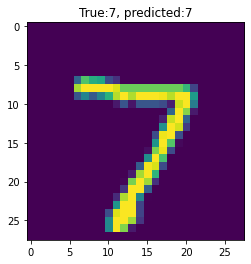

In [15]:
import matplotlib.pylab as plt

plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

Now test the quantized model (using the uint8 data):

In [16]:
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]
interpreter_quant.set_tensor(input_index, test_image)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index)

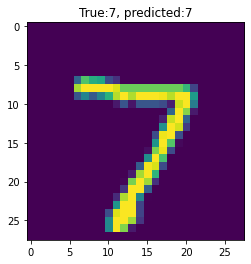

In [17]:
plt.imshow(test_images[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

### Evaluate the models

In [18]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [19]:
print(evaluate_model(interpreter))

0.9636


Repeat the evaluation on the fully quantized model using the uint8 data:

In [20]:
# NOTE: Colab runs on server CPUs, and TensorFlow Lite currently
# doesn't have super optimized server CPU kernels. So this part may be
# slower than the above float interpreter. But for mobile CPUs, considerable
# speedup can be observed.

print(evaluate_model(interpreter_quant))

0.9633


In this example, you have fully quantized a model with almost no difference in the accuracy, compared to the above float model.